In progress... work, there will be quite a number of grammatical errors and some things will be incomplete

# Example 2; Datasets and custom models

As the name suggests, this example is split into two parts.


* Deep dive into `System_data` and generation
  * Creating basic systems for data generation.
  * Combining multiple datasets
  * Downloading popular Datasets
  * MIMO 

* Estimation
  * Normalization.
  * creating your own SS_encoder_general system (grey box model)
  * .fit features
  * Memory Saving measures

# 1. Deep dive into `System_data`

## 1.1 Generating the data with deepSI

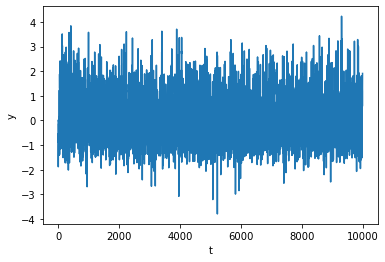

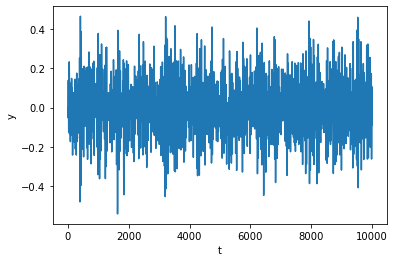

In [9]:
import deepSI
import numpy as np

#state-space models
class My_sys(deepSI.System_ss):
    def __init__(self):
        super(My_sys, self).__init__(nx=2)
    def f(self,x,u): #state function
        return x[0]/(1.2+x[1]**2)+x[1]*0.4, x[1]/(1.2+x[0]**2)+x[0]*0.4+u*(1+x[0]**2/10)
    def h(self,x): #output functions
        return x[1]*x[0]*0.1+x[0]

sys = My_sys()
N = 10_000
data = sys.apply_experiment(deepSI.System_data(u=np.random.normal(size=N)*1.5))
data.plot(show=True) #plt.plot(data.y)

#state-space as ODE models
class My_sys(deepSI.System_deriv): #1 step RK4 integration
    def __init__(self):
        super(My_sys, self).__init__(nx=2, dt=0.1)
        
    def deriv(self,x,u):
        p,v = x
        dp = v
        dv = -5*p-p**3-v/2+u
        return [dp,dv]

    def h(self,x):
        return x[0]
    
sys = My_sys()
data = sys.apply_experiment(deepSI.System_data(u=np.random.normal(size=N)))
data.plot(show=True)

## 1.2 Combining multiple seperate datasets

datasets= System_data_list with 20 series and total length 20000, nu=None, ny=None, normed=False lengths=[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000] dt=None


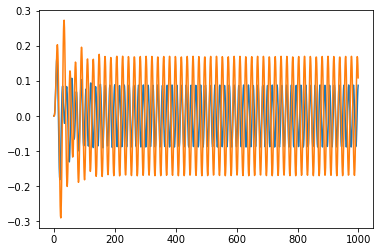

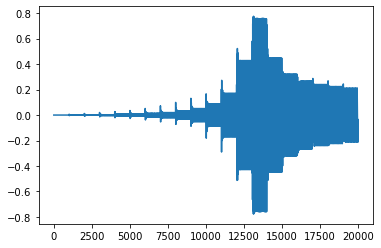

In [15]:
from deepSI import System_data, System_data_list
from matplotlib import pyplot as plt
sys = My_sys()
datasets = System_data_list() #a custom list type
N = 1000
for tau in np.geomspace(2,100,num=20):
    exp = deepSI.System_data(u = np.sin(np.arange(N)/tau*2*np.pi))
    dataset = sys.apply_experiment(exp)
    datasets.append(dataset)
print('datasets=',datasets)
plt.plot(datasets[10].y) #indexing works as normal
plt.plot(datasets[11].y)
plt.show()
plt.plot(datasets.y) #will concatinate all the y of all datasets, be carful when using this
plt.show()

NRMS sim linear 0.12695971732699807


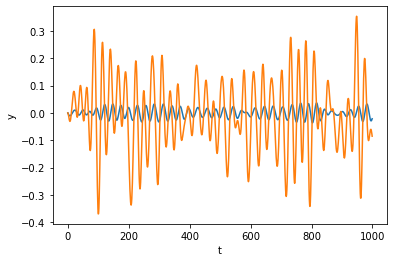

In [13]:
#create a test set.
exp = deepSI.System_data(u=deepSI.exp_design.filtered_signal(1000,fmax=0.1))
test = sys.apply_experiment(exp)

sys = deepSI.fit_systems.Sklearn_io_linear(2,2)
sys.fit(datasets) #use the multiple datasets

test_sim = sys.apply_experiment(test)
print('NRMS sim linear',test_sim.NRMS(test))
(test-test_sim).plot()
test.plot()

## 1.3 Downloading popular Datasets

* You can pull most datasets from https://www.nonlinearbenchmark.org/ and DaISy https://homes.esat.kuleuven.be/~tokka/daisydata.html
  * If some of these don't work feel free to contact me
* They will be saved in a temp directory in `C:\Users\thisuser\AppData\Local\deepSI\data_sets/` (windows)
  * `deepSI.datasets.get_work_dirs()['data_sets']` will provide the directories


file not found downloading from ftp://ftp.esat.kuleuven.ac.be/pub/SISTA/data/mechanical/ballbeam.dat.gz 
 in C:\Users\gerben\AppData\Local\deepSI/data_sets/DaISy_data\ballbeam.dat.gz
extracting file...


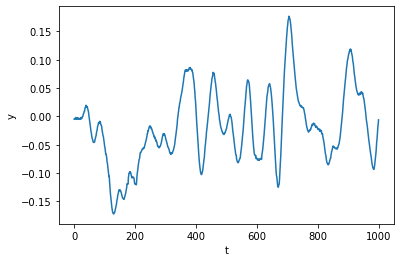

file not found downloading from https://data.4tu.nl/ndownloader/files/24686327 
 in C:\Users\gerben\AppData\Local\deepSI/data_sets/Cascaded_Tanks\CascadedTanksFiles.zip


100% |########################################################################|


extracting file...
System_data_list with 2 series and total length 2048, nu=None, ny=None, normed=False lengths=[1024, 1024] dt=None


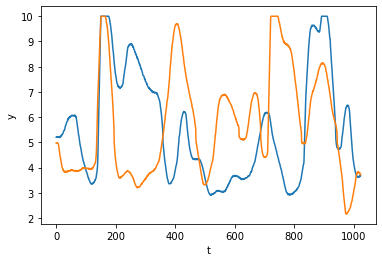

In [26]:
ballbeam_data = deepSI.datasets.sista_database.ballbeam(dir_placement=None, #will download to Local folder
    force_download=True, # force the dataset to be (re-)downlaoded
    split_data=False, #automatic split the data into train and test. (Might not be optimal, check this!)
)
ballbeam_data.plot(show=True)

CTS_data = deepSI.datasets.Cascaded_Tanks(dir_placement=None, #will download to Local folder
    force_download=True, # force the dataset to be (re-)downlaoded
    split_data=False, #automatic split the data into train and test. (Might not be optimal, check this!)
)
print(CTS_data) #contais 2 datasets
train, test = CTS_data
train.plot()
test.plot()
plt.show()


## 1.4 Multiple inputs and Multiple outputs (MIMO) datasets

Some datasets have multiple input and multiple outputs which can be obtained by calling `ny` for the number of outputs and `nu` for the number of inputs. example;

In [38]:
sys_data = deepSI.datasets.CED(split_data=False) #SISO
print('######## CED ########')
print(sys_data)
print(f'u.shape={sys_data.u.shape}, nu={sys_data.nu}')
print(f'y.shape={sys_data.y.shape}, ny={sys_data.ny}')


sys_data = deepSI.datasets.sista_database.erie(split_data=False) #SISO
print('\n####### erie ########')
print(sys_data)
print(f'u.shape={sys_data.u.shape}, nu={sys_data.nu}')
print(f'y.shape={sys_data.y.shape}, ny={sys_data.ny}')

######## CED ########
System_data_list with 2 series and total length 1000, nu=None, ny=None, normed=False lengths=[500, 500] dt=None
u.shape=(1000,), nu=None
y.shape=(1000,), ny=None

####### erie ########
System_data of length: 57 nu=5 ny=2 normed=False dt=None
u.shape=(57, 5), nu=5
y.shape=(57, 2), ny=2


Not that `None` is used if the second dimention is absent. The full conversion list can be seen below:

```
y.shape = (Ntime,) -> ny = None
y.shape = (Ntime,1) -> ny = 1
y.shape = (Ntime,0) -> ny = 0 #zero is possible but not common
y.shape = (Ntime,123) -> ny = 123 #int
y.shape = (Ntime,3,3) -> ny = (3,3) #tuple
```

# 2 Custom Estimation

## 2.1 Normalization

When using neural networks `u` and `y` normalization is essential for good gradient propogation. This comes from the assumption made in [Xavier Weight initialization](https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) that both the input and the output are within normal range. 

For this reason all systems contain a `.norm` object which can be viewed and altered. 

In [51]:
sys = deepSI.fit_systems.SS_encoder()
print(sys.norm) #u0 is mean


train, test = deepSI.datasets.Silverbox()
sys.norm.fit(train) #initialize weights
print(sys.norm)

train_normed = sys.norm.transform(train)
print('original:')
print('u mean=',np.mean(train.u),'u std=',np.std(train.u))
print('y mean=',np.mean(train.y),'y std=',np.std(train.y))
print('Normalized:')
print('u mean=',np.mean(train_normed.u),'u std=',np.std(train_normed.u))
print('y mean=',np.mean(train_normed.y),'y std=',np.std(train_normed.y))



System_data_norm: (u0=0, ustd=1, y0=0, ystd=1)
System_data_norm: (u0=0.006142380733678717, ustd=0.02221031158562284, y0=0.0007860185372262015, ystd=0.054543655886918736)
original:
u mean= 0.006142380733678717 u std= 0.02221031158562184
y mean= 0.0007860185372262015 y std= 0.05454365588691774
Normalized:
u mean= -1.1139429935681383e-17 u std= 0.999999999999955
y mean= -1.594467422166159e-17 y std= 0.9999999999999817


This `.norm` will be fitted the first time that `.fit` is called unless explicitly disabled by setting `sys.use_norm=False`. example;

In [60]:
sys = deepSI.fit_systems.SS_encoder()
sys.norm.u0 = 10
sys.norm.ystd = 10
train, test = deepSI.datasets.Silverbox()
sys.fit(train,epochs=0,verbose=0)
print('1.',sys.norm) #altered
sys.fit(test,epochs=0,verbose=0)
print('1.1',sys.norm) #un-altered

sys = deepSI.fit_systems.SS_encoder()
sys.use_norm = False
sys.norm.u0 = 10
sys.norm.ystd = 10
train, test = deepSI.datasets.Silverbox()
sys.fit(train,epochs=0,verbose=0)
print('2.',sys.norm) #un-altered



1. System_data_norm: (u0=0.006142380733678717, ustd=0.02221031158562284, y0=0.0007860185372262015, ystd=0.054543655886918736)
1.1 System_data_norm: (u0=0.006142380733678717, ustd=0.02221031158562284, y0=0.0007860185372262015, ystd=0.054543655886918736)
2. System_data_norm: (u0=10, ustd=1, y0=0, ystd=10)


**Causion!** When a dataset is MIMO the normalization will be applied element wise. 

In this case I would recommend using your intuition what would be the most effective normalization and using `use_norm=False`.

System_data_norm: (u0=99.85399256358356, ustd=3.887966721490943, y0=[8.89121129e-02 4.41274567e+02], ystd=[0.01309719 3.06124072])


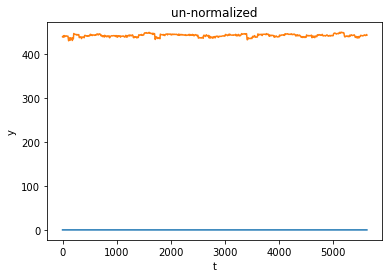

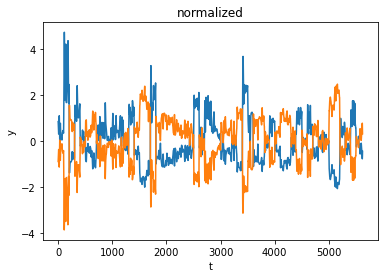

In [80]:
train, test = deepSI.datasets.sista_database.cstr() #MIMO (nu=None, ny=2)
sys = deepSI.fit_systems.SS_encoder()
sys.fit(train,epochs=0,verbose=0)
print(sys.norm) #element wise norm

plt.title('un-normalized')
train.plot()
plt.show()

plt.title('normalized')
sys.norm.transform(train).plot()
plt.show()

## 2.2 Creating your own encoder structure 

Lets make a model with the following linear affine structure

$$
x_{k+1} = A x_k + B(x_k) u_k \\
y_k = C x_k
$$

In [10]:
from torch import nn
import deepSI
import numpy as np
import torch

class My_encoder_net(nn.Module): #a simple FC net with a residual (defaulth appraoch)
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(My_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod(self.ny,dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class My_state_net(nn.Module): #
    def __init__(self, nx, nu, nodes_per_layer=20):
        super(My_state_net, self).__init__()
        self.nu = nu
        self.nx = nx
        nu = 1 if nu==None else nu
        self.Apart = nn.Linear(nx, nx)
        self.Bpart =  nn.Sequential(nn.Linear(nx, nodes_per_layer), nn.Tanh(), nn.Linear(nodes_per_layer,nx*nu))

    def forward(self, x, u):
        #first dimention is always the batch dimention
        # x shape: (Nb, 1)
        # u shape: (Nb)
        if self.nu == None:
            u = u[:,None] #convert to (Nb,1) if needed
        Blin = self.Bpart(x)
        Bmat = Blin.view(x.shape[0], self.nx, 1 if self.nu==None else nu)
        
        return self.Apart(x) + torch.einsum('bij,bj->bi',Bmat, u)

class My_output_net(nn.Module):
    def __init__(self, nx, ny):
        super(My_output_net, self).__init__()
        self.ny = ny
        self.Cpart = nn.Linear(nx, 1 if ny==None else ny)

    def forward(self, x):
        #first dimention is always the batch dimention
        y = self.Cpart(x)
        if self.ny is None:
            return y[:,0]
        else:
            return y
    

fit_sys = deepSI.fit_systems.SS_encoder_general(nx=2, na=5, nb=5, \
                                                e_net=My_encoder_net, e_net_kwargs=dict(n_nodes_per_layer=20),\
                                                f_net=My_state_net, f_net_kwargs=dict(nodes_per_layer=20),\
                                                h_net=My_output_net)

train, test = deepSI.datasets.Cascaded_Tanks()

fit_sys.fit(train,epochs=500,sim_val=test)



Size of the training array =  466.4 kB
N_training_samples = 995, batch_size = 256, N_batch_updates_per_epoch = 3
Initial Validation NRMS= 1.3431730691409967


  0%|          | 0/500 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 1.332408684385059
Epoch    1, sqrt loss   1.275, Val NRMS  1.332, Time Loss: 22.7%, data: 1.3%, val: 76.0%, 17.8 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.3223316784760064
Epoch    2, sqrt loss   1.256, Val NRMS  1.322, Time Loss: 22.9%, data: 0.7%, val: 76.4%, 18.8 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.312855905973523
Epoch    3, sqrt loss   1.258, Val NRMS  1.313, Time Loss: 22.8%, data: 0.4%, val: 76.7%, 19.0 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.3036608335849276
Epoch    4, sqrt loss    1.25, Val NRMS  1.304, Time Loss: 22.8%, data: 0.7%, val: 76.5%, 19.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.294833694401931
Epoch    5, sqrt loss   1.258, Val NRMS  1.295, Time Loss: 22.5%, data: 0.8%, val: 76.7%, 19.3 batches/sec
########## New lowest validation loss achie

########## New lowest validation loss achieved ########### NRMS = 1.0699536195333095
Epoch   45, sqrt loss    0.98, Val NRMS   1.07, Time Loss: 21.8%, data: 0.9%, val: 77.2%, 19.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.0664918877862108
Epoch   46, sqrt loss  0.9812, Val NRMS  1.066, Time Loss: 21.8%, data: 1.0%, val: 77.2%, 19.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.0632694717154456
Epoch   47, sqrt loss  0.9788, Val NRMS  1.063, Time Loss: 21.8%, data: 1.0%, val: 77.2%, 19.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.0603609166475347
Epoch   48, sqrt loss  0.9711, Val NRMS   1.06, Time Loss: 21.8%, data: 0.9%, val: 77.2%, 19.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 1.0576772478492804
Epoch   49, sqrt loss  0.9949, Val NRMS  1.058, Time Loss: 21.9%, data: 0.9%, val: 77.1%, 19.2 batches/sec
########## New lowest validation loss ac

########## New lowest validation loss achieved ########### NRMS = 0.9965383803093826
Epoch   89, sqrt loss  0.9026, Val NRMS 0.9965, Time Loss: 22.1%, data: 0.9%, val: 77.0%, 19.4 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.9962807612413032
Epoch   90, sqrt loss  0.8979, Val NRMS 0.9963, Time Loss: 22.1%, data: 0.9%, val: 77.0%, 19.4 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.9960420910462723
Epoch   91, sqrt loss  0.9005, Val NRMS  0.996, Time Loss: 22.1%, data: 0.9%, val: 77.0%, 19.4 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.9957082481253161
Epoch   92, sqrt loss  0.9078, Val NRMS 0.9957, Time Loss: 22.1%, data: 0.9%, val: 77.0%, 19.4 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.9953412239294783
Epoch   93, sqrt loss  0.8952, Val NRMS 0.9953, Time Loss: 22.1%, data: 0.9%, val: 77.0%, 19.4 batches/sec
########## New lowest validation loss ac

Epoch  139, sqrt loss  0.7809, Val NRMS 0.9662, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  140, sqrt loss  0.7688, Val NRMS  0.967, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  141, sqrt loss  0.7481, Val NRMS 0.9714, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  142, sqrt loss  0.7439, Val NRMS  0.974, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  143, sqrt loss  0.7414, Val NRMS 0.9738, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  144, sqrt loss   0.732, Val NRMS 0.9717, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  145, sqrt loss  0.7193, Val NRMS 0.9671, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.6 batches/sec
Epoch  146, sqrt loss  0.7085, Val NRMS  0.969, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  147, sqrt loss   0.693, Val NRMS 0.9752, Time Loss: 22.3%, data: 0.8%, val: 76.9%, 19.5 batches/sec
Epoch  148, sqrt loss  0.6837, Val NR

########## New lowest validation loss achieved ########### NRMS = 0.7949100820707391
Epoch  211, sqrt loss  0.2524, Val NRMS 0.7949, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.7561669836924636
Epoch  212, sqrt loss  0.2507, Val NRMS 0.7562, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  213, sqrt loss  0.2455, Val NRMS 0.7587, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  214, sqrt loss  0.2453, Val NRMS  0.766, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  215, sqrt loss  0.2409, Val NRMS 0.7687, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.7422951194342213
Epoch  216, sqrt loss  0.2445, Val NRMS 0.7423, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.7147241286178152
Epoch  217, sqrt l

Epoch  267, sqrt loss  0.2073, Val NRMS 0.5536, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.5452436060850393
Epoch  268, sqrt loss  0.2062, Val NRMS 0.5452, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  269, sqrt loss  0.2088, Val NRMS 0.5465, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  270, sqrt loss  0.2052, Val NRMS 0.5615, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  271, sqrt loss   0.206, Val NRMS 0.5574, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  272, sqrt loss  0.2072, Val NRMS 0.5455, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  273, sqrt loss  0.2051, Val NRMS 0.5484, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  274, sqrt loss  0.2059, Val NRMS 0.5551, Time Loss: 22.5%, data: 0.7%, val: 76.8%, 19.5 batches/sec
Epoch  275, sqrt loss   0.206, Val NRMS 0.5516, Time Loss: 

Epoch  343, sqrt loss  0.1904, Val NRMS 0.5519, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  344, sqrt loss  0.1905, Val NRMS 0.5484, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  345, sqrt loss  0.1907, Val NRMS 0.5475, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  346, sqrt loss  0.1918, Val NRMS 0.5367, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  347, sqrt loss  0.1896, Val NRMS 0.5363, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.5 batches/sec
Epoch  348, sqrt loss   0.194, Val NRMS 0.5515, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.6 batches/sec
Epoch  349, sqrt loss  0.1926, Val NRMS 0.5499, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.6 batches/sec
Epoch  350, sqrt loss  0.1941, Val NRMS 0.5445, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.6 batches/sec
Epoch  351, sqrt loss  0.1902, Val NRMS  0.537, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.6 batches/sec
Epoch  352, sqrt loss  0.1891, Val NR

Epoch  417, sqrt loss  0.1839, Val NRMS 0.5391, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  418, sqrt loss  0.1842, Val NRMS 0.5399, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  419, sqrt loss   0.184, Val NRMS  0.529, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  420, sqrt loss  0.1836, Val NRMS 0.5381, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  421, sqrt loss  0.1782, Val NRMS 0.5406, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  422, sqrt loss  0.1813, Val NRMS 0.5372, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  423, sqrt loss  0.1844, Val NRMS 0.5276, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  424, sqrt loss  0.1788, Val NRMS 0.5354, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  425, sqrt loss  0.1802, Val NRMS 0.5402, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  426, sqrt loss  0.1849, Val NR

Epoch  493, sqrt loss  0.1771, Val NRMS 0.5353, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  494, sqrt loss  0.1761, Val NRMS 0.5343, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  495, sqrt loss  0.1765, Val NRMS 0.5388, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  496, sqrt loss  0.1753, Val NRMS  0.554, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  497, sqrt loss  0.1725, Val NRMS 0.5372, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  498, sqrt loss  0.1747, Val NRMS 0.5368, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  499, sqrt loss  0.1734, Val NRMS 0.5455, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Epoch  500, sqrt loss  0.1731, Val NRMS 0.5321, Time Loss: 22.5%, data: 0.7%, val: 76.7%, 19.7 batches/sec
Loaded model with best known validation NRMS of 0.5259 which happened on epoch 486 (epoch_id=486.00)


### Testing components

In [ ]:
# fit_sys.parameters = fit_sys.init_nets(None,None) #init the network callaed as e_net(**e_net_kwargs) 
# test_p = fit_sys.apply_experiment(test)
# test.plot()
# (test_p-test).plot()
# plt.show()
# test_p.NRMS(test) #3.2e-8

Also see Encoder-grey-box-approach-alpha.ipynb

.fit advances such as saving memory

* cuda? 